### Imports

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import plot_importance

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression

from torch import nn
import neural_network
import losses
import torch

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

c:\Users\Benja\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# df = pd.read_csv("../data/clean2_data_normalized.csv", index_col=0)
df = pd.read_csv("../data/cleaned_data_ext_norm.csv", index_col=0)

In [3]:
seed = 100
test_size = 0.15
X = df.drop(columns=["TARGET", "SK_ID_CURR"], axis=1)
y = df["TARGET"]

k = 10
kf = KFold(n_splits=k, random_state=None)


# note: stratify=df.buy generates
# X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
# classes_weights = class_weight.compute_sample_weight(
#     class_weight='balanced',
#     y=y_train
# )

In [4]:
logreg = LogisticRegression(class_weight='balanced', max_iter=10000)

best_log_model = None
log_f1_scores = []
max_log_f1 = 0
log_Xtr, log_Xte, log_ytr, log_yte = None, None, None, None


for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    logreg.fit(X_train,y_train)
    pred_values = logreg.predict(X_test)
     
    f1_te = f1_score(y_test, pred_values)
    log_f1_scores.append(f1_te)
    if f1_te > max_log_f1:
        max_log_f1 = f1_te
        best_log_model = logreg
        log_Xtr, log_Xte, log_ytr, log_yte = X_train, X_test, y_train, y_test

print("Best F1: ", max_log_f1)
print(log_f1_scores)
print(np.mean(log_f1_scores))

Best F1:  0.26065209336791406
[0.25356019974107635, 0.2560629633019127, 0.2559614182370278, 0.25927614185431674, 0.2530649588289112, 0.2501608308059921, 0.25315755508435517, 0.26065209336791406, 0.2588899341486359, 0.24581410082360397]
0.25466001961937457


In [5]:
tn, fp, fn, tp = confusion_matrix(log_yte, best_log_model.predict(log_Xte)).ravel()
tn, fp, fn, tp

(17102, 7355, 627, 1405)

In [6]:
total = sum([tn,fp,fn,tp])
print("FNR: ", fn/total)
print("FPR: ", fp/total)

FNR:  0.023670202725659707
FPR:  0.277662425912643


In [96]:
best_tree_model = None
max_tree_f1 = 0
tree_f1_scores = []
tree_Xtr, tree_Xte, tree_ytr, tree_yte = None, None, None, None

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )

    xgb_model = XGBClassifier(base_score=np.sum(y_train == 0)/len(y_train), max_depth=4, n_estimators = 500, subsample=0.8, reg_lambda = 1)
    xgb_model.fit(X_train, y_train, sample_weight=classes_weights)
     
    pred_values = xgb_model.predict(X_test)
     
    f1_te = f1_score(y_test, pred_values)
    tree_f1_scores.append(f1_te)
    if f1_te > max_tree_f1:
        max_tree_f1 = f1_te
        best_tree_model = xgb_model
        tree_Xtr, tree_Xte, tree_ytr, tree_yte = X_train, X_test, y_train, y_test

print("Best F1: ", max_tree_f1)
print(tree_f1_scores)
print(np.mean(tree_f1_scores))

Best F1:  0.2716582155572338
[0.26846513651691506, 0.2663637347181651, 0.2709188506473003, 0.2716582155572338, 0.270554185872012, 0.2626240593303523, 0.26501843417913684, 0.27074904319300164, 0.2696007961959527, 0.2602363866610384]
0.26761888428711084


In [97]:
tn, fp, fn, tp = confusion_matrix(tree_yte, best_tree_model.predict(tree_Xte)).ravel()
tn, fp, fn, tp

(18480, 5917, 834, 1259)

In [98]:
total = sum([tn,fp,fn,tp])
print("FNR: ", fn/total)
print("FPR: ", fp/total)

FNR:  0.031483578708946774
FPR:  0.22336730841827104


In [99]:
feat_dict= {}
for col, val in sorted(zip(X_train.columns, best_tree_model.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df[:10]

,Feature,Importance
0,Higher education,0.055314
1,EXT_SOURCE_3,0.039838
2,CODE_GENDER,0.033309
3,EXT_SOURCE_2,0.022632
4,Working,0.017839
5,car_owned_less_10,0.017379
6,NAME_CONTRACT_TYPE,0.016591
7,REGION_RATING_CLIENT_W_CITY,0.010916
8,Secondary / secondary special,0.010884
9,Self-employed,0.010806


Text(0.5, 0, 'Importance')

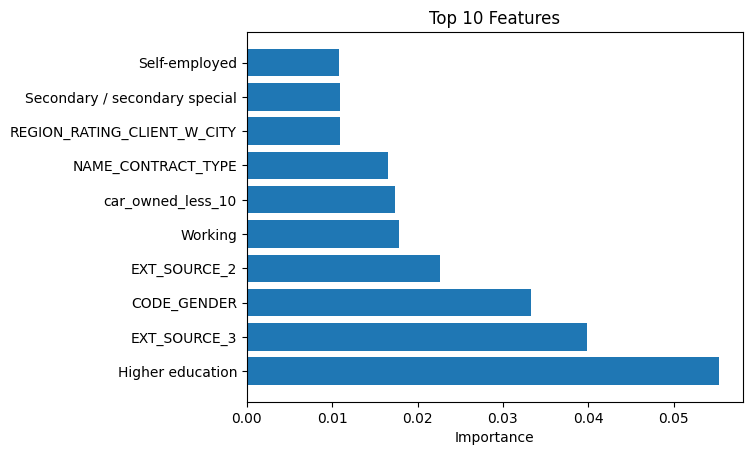

In [100]:
plt.barh(feat_df[:10]['Feature'], feat_df[:10]['Importance'])
plt.title("Top 10 Features")
plt.xlabel("Importance")

In [12]:
#Our rating of the region where client lives with taking city into account (1,2,3)
#organization type	


In [13]:
best_nn_model = None
max_nn_f1 = 0
nn_f1_scores = []
nn_Xtr, nn_Xte, nn_ytr, nn_yte = None, None, None, None

output_dim = 1
num_epochs = 1000

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]


    n, d = X_train.shape
    input_dim = d
    hidden_dim = d//2
    model_nn = neural_network.Model(input_dim, hidden_dim, output_dim)

    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )

    
    model_nn = neural_network.train_regression_model(torch.tensor(X_train.values, dtype=torch.float32), 
                                        torch.tensor(y_train.values, dtype=torch.float32), 
                                        model_nn, 
                                        num_epochs, 
                                        loss_fn = losses.DiceBCELoss(weight=torch.tensor(classes_weights)),
                                        lr=1e-3, print_freq=25, display_loss=False)

    model_nn.eval()

    y_pred_te = model_nn(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()
    y_pred_te = np.round(y_pred_te)
     
    f1_te = f1_score(y_test, y_pred_te)
    nn_f1_scores.append(f1_te)
    if f1_te > max_nn_f1:
        max_nn_f1 = f1_te
        best_nn_model = model_nn
        nn_Xtr, nn_Xte, nn_ytr, nn_yte = X_train, X_test, y_train, y_test

print("Best F1: ", max_nn_f1)
print(nn_f1_scores)
print(np.mean(nn_f1_scores))

Best F1:  0.26693877551020406
[0.25527258257063273, 0.2632340777502068, 0.25992710531363894, 0.2597506234413965, 0.2585461689587426, 0.24915824915824916, 0.25417439703153993, 0.26693877551020406, 0.26588040554521, 0.25351246026048607]
0.25863948455403063


In [14]:
y_pred_te = best_nn_model(torch.tensor(nn_Xte.values, dtype=torch.float32)).detach().numpy().flatten()
y_pred_te = np.round(y_pred_te)

tn, fp, fn, tp = confusion_matrix(nn_yte, y_pred_te).ravel()
tn, fp, fn, tp

(17997, 6460, 724, 1308)

In [15]:
total = sum([tn,fp,fn,tp])
print("FNR: ", fn/total)
print("FPR: ", fp/total)

FNR:  0.02733210011702971
FPR:  0.24387481596134244


### Linear Regression --> Might want to switch this to soft SVM classifier bec this is not a regression task

In [16]:
# # linear model 
# x = sm.add_constant(X_train, prepend=False)
# lin_mod = sm.OLS(y_train, x.astype(float))
# lin_mod = lin_mod.fit()
# # print(lin_mod.summary())

In [17]:
# y_pred_tr = lin_mod.predict(x.astype(float))
# y_pred_te = lin_mod.predict(sm.add_constant(X_test, prepend=False).astype(float))

# accuracy_tr = accuracy_score(y_train, y_pred_tr)
# print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

# accuracy_te = accuracy_score(y_test, y_pred_te)
# print("Test Accuracy: %.2f%%" % (accuracy_te * 100.0))

# print('f1 score on train set', f1_score(y_train, y_pred_tr))
# print('f1 score on test set', f1_score(y_test, y_pred_te))

### Logistic Regression

In [18]:
logreg = LogisticRegression(class_weight='balanced', max_iter=100000)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=100000)

In [101]:
accuracy_tr = accuracy_score(y_train, logreg.predict(X_train))
print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

accuracy_te = accuracy_score(y_test, logreg.predict(X_test))
print("Test Accuracy: %.2f%%" % (accuracy_te * 100.0))

Train Accuracy: 69.40%
Test Accuracy: 68.54%


In [19]:
f1_tr = f1_score(y_train, logreg.predict(X_train))
print('f1 score on train set', f1_tr)

f1_te = f1_score(y_test, logreg.predict(X_test))
print('f1 score on test set', f1_te)

f1 score on train set 0.25656440092518057
f1 score on test set 0.24581410082360397


In [109]:
def get_FNR_FPR(yTr, y_pred): 
  tn, fp, fn, tp = confusion_matrix(yTr, y_pred).ravel()
  total = sum([tn,fp,fn,tp])
  print("FNR: ", fn/(fn+tp))
  print("FPR: ", fp/(fp+tn))

print('train')
get_FNR_FPR(y_train, logreg.predict(X_train))
print('test')
get_FNR_FPR(y_test, logreg.predict(X_test))

train
FNR:  0.31920186016330504
FPR:  0.30494015788133433
test
FNR:  0.3199799699549324
FPR:  0.31414339376122813


In [20]:
print('Classification Report for Train Set: \n', classification_report(y_train, logreg.predict(X_train)))
print('Classification Report for Test Set: \n', classification_report(y_test, logreg.predict(X_test)))

Classification Report for Train Set: 
               precision    recall  f1-score   support

           0       0.96      0.70      0.81    219912
           1       0.16      0.68      0.26     18493

    accuracy                           0.69    238405
   macro avg       0.56      0.69      0.53    238405
weighted avg       0.90      0.69      0.76    238405

Classification Report for Test Set: 
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     24492
           1       0.15      0.68      0.25      1997

    accuracy                           0.69     26489
   macro avg       0.56      0.68      0.52     26489
weighted avg       0.90      0.69      0.76     26489



In [21]:
tn, fp, fn, tp = confusion_matrix(y_train, logreg.predict(X_train)).ravel()
tn, fp, fn, tp

(152852, 67060, 5903, 12590)

In [60]:
print(roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))

0.752788293758486
0.7474679886888964


### Extreme Gradient Boosted Trees


https://xgboost.readthedocs.io/en/stable/parameter.html

In [72]:
xgb_model = XGBClassifier(base_score=np.sum(y_train == 0)/len(y_train), max_depth=4, n_estimators = 500, subsample=0.8, reg_lambda = 1)
xgb_model.fit(X_train, y_train, sample_weight=classes_weights)

XGBClassifier(base_score=0.9224303181560789, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [73]:
y_pred_tr = xgb_model.predict(X_train)
y_pred_te = xgb_model.predict(X_test)

accuracy_tr = accuracy_score(y_train, y_pred_tr)
print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

accuracy_te = accuracy_score(y_test, y_pred_te)
print("Test Accuracy: %.2f%%" % (accuracy_te * 100.0))

print('f1 score on train set', f1_score(y_train, y_pred_tr))
print('f1 score on test set', f1_score(y_test, y_pred_te))

Train Accuracy: 77.31%
Test Accuracy: 73.54%
f1 score on train set 0.3589895495153913
f1 score on test set 0.2602363866610384


In [74]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_tr).ravel()
tn, fp, fn, tp

(169156, 50756, 3344, 15149)

In [75]:
# estimator = 750, max dept = 5
# 0.9586068613107632
# 0.7236695726261284

# estimator = 750, max depth = 4
# 0.9055750867421488
# 0.7365565128682735
# f1 score on train set 0.4022326704045458
# f1 score on test set 0.26200476785106136

# estimator = 500, max dept = 3
# roc_auc 0.8739104744605009
# 0.745080792837140
# f1 score on train set 0.3589895495153913
# f1 score on test set 0.260236386
print(roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))

0.8739104744605009
0.7450807928371407


In [110]:
print('train')
get_FNR_FPR(y_train, xgb_model.predict(X_train))
print('test')
get_FNR_FPR(y_test, xgb_model.predict(X_test))

train
FNR:  0.1808251770940356
FPR:  0.23080141147368038
test
FNR:  0.38257386079118677
FPR:  0.25502204801567857


In [103]:
feat_dict= {}
for col, val in sorted(zip(X_train.columns, xgb_model.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df

,Feature,Importance
0,EXT_SOURCE_3,0.038267
1,CODE_GENDER,0.034988
2,Higher education,0.030950
3,EXT_SOURCE_2,0.025006
4,car_owned_less_10,0.021769
...,...,...
147,Student,0.000000
148,Unemployed,0.000000
149,Realty agents,0.000000
150,Religion,0.000000


Text(0.5, 0, 'Importance')

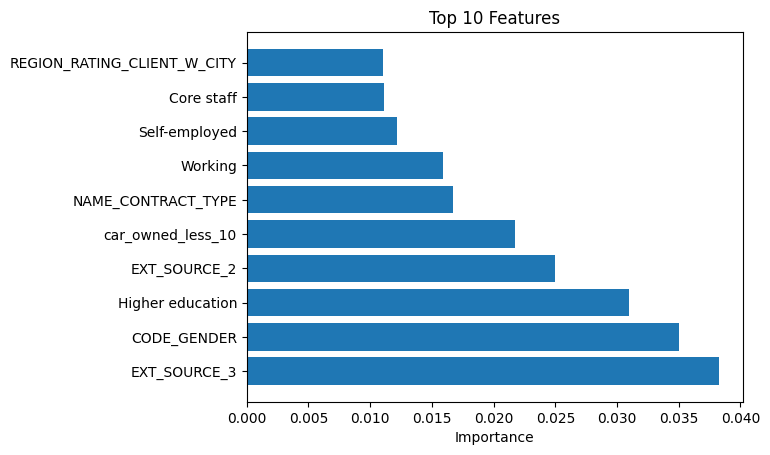

In [104]:
plt.barh(feat_df[:10]['Feature'], feat_df[:10]['Importance'])
plt.title("Top 10 Features")
plt.xlabel("Importance")

### Neural Network

In [28]:
n, d = X_train.shape
input_dim = d
hidden_dim = d//2
output_dim = 1
num_epochs = 1000
model_nn = neural_network.Model(input_dim, hidden_dim, output_dim)

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',# {0: len(y_train)/np.sum(y_train == 0), 1: 1.5 * len(y_train)/np.sum(y_train == 1)},
    y=y_train
)

model_nn = neural_network.train_regression_model(torch.tensor(X_train.values, dtype=torch.float32), 
                                      torch.tensor(y_train.values, dtype=torch.float32), 
                                      model_nn, 
                                      num_epochs, 
                                      loss_fn = losses.DiceBCELoss(weight=torch.tensor(classes_weights)),
                                      # loss_fn = losses.DiceLoss(),
                                      # loss_fn = nn.BCELoss(weight=torch.tensor(classes_weights)), 
                                      lr=1e-3, print_freq=25, display_loss=True)

epoch 25 loss 1.5146561861038208
epoch 50 loss 1.4808791875839233
epoch 75 loss 1.455309510231018
epoch 100 loss 1.4343223571777344
epoch 125 loss 1.4201583862304688
epoch 150 loss 1.4108566045761108
epoch 175 loss 1.405050277709961
epoch 200 loss 1.4017584323883057
epoch 225 loss 1.3998295068740845
epoch 250 loss 1.3983782529830933
epoch 275 loss 1.3970742225646973
epoch 300 loss 1.3956353664398193
epoch 325 loss 1.3939599990844727
epoch 350 loss 1.392240047454834
epoch 375 loss 1.3904547691345215
epoch 400 loss 1.3886477947235107
epoch 425 loss 1.386717438697815
epoch 450 loss 1.3847002983093262
epoch 475 loss 1.382570743560791
epoch 500 loss 1.3804457187652588
epoch 525 loss 1.3783395290374756
epoch 550 loss 1.3763811588287354
epoch 575 loss 1.3746116161346436
epoch 600 loss 1.3729181289672852
epoch 625 loss 1.3713226318359375
epoch 650 loss 1.3697786331176758
epoch 675 loss 1.368293285369873
epoch 700 loss 1.3668866157531738
epoch 725 loss 1.365535020828247
epoch 750 loss 1.3642858

In [29]:
model_nn.eval()

y_pred_tr = model_nn(torch.tensor(X_train.values, dtype=torch.float32)).detach().numpy().flatten()
y_pred_tr = np.round(y_pred_tr)
y_pred_te = model_nn(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()
y_pred_te = np.round(y_pred_te)

accuracy_tr = accuracy_score(y_train, y_pred_tr)
print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

accuracy_te = accuracy_score(y_test, y_pred_te)
print("Test Accuracy: %.2f%%" % (accuracy_te * 100.0))

print('f1 score on train set', f1_score(y_train, y_pred_tr))
print('f1 score on test set', f1_score(y_test, y_pred_te))

Train Accuracy: 73.93%
Test Accuracy: 72.63%
f1 score on train set 0.2871593724194881
f1 score on test set 0.25656275635767023


In [30]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_tr).ravel()
tn, fp, fn, tp

(163732, 56180, 5974, 12519)

In [57]:
print(roc_auc_score(y_train, model_nn(torch.tensor(X_train.values, dtype=torch.float32)).detach().numpy().flatten()))
print(roc_auc_score(y_test, model_nn(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()))

0.782616236030502
0.7429161462265259


In [112]:
print('train')
get_FNR_FPR(y_train, np.round(model_nn(torch.tensor(X_train.values, dtype=torch.float32)).detach().numpy().flatten()))
print('test')
get_FNR_FPR(y_test, np.round(model_nn(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()))

train
FNR:  0.3230411507056724
FPR:  0.25546582269271345
test
FNR:  0.37356034051076614
FPR:  0.26555609995100443


Text(0.5, 1.0, 'Train Precision-Recall curve')

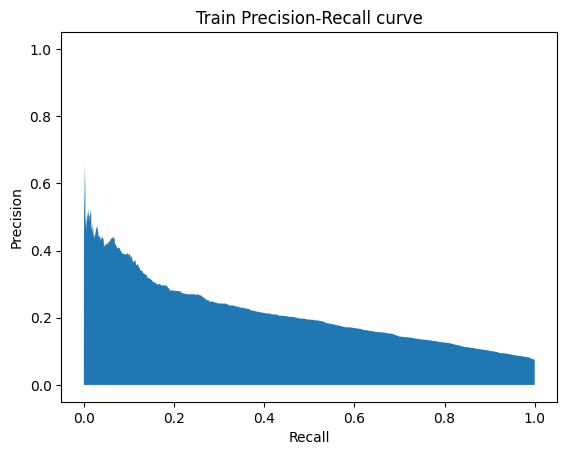

In [77]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve")

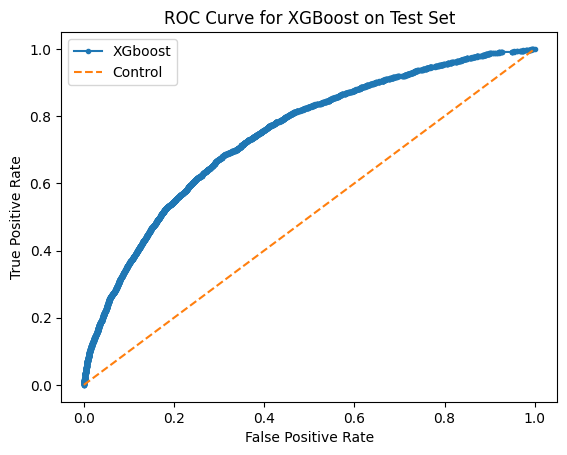

In [113]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='XGboost')
# axis labels
plt.plot([0, 1], [0, 1], linestyle='--', label='Control')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('ROC Curve for XGBoost on Test Set')
# show the plot
plt.show()

Text(0.5, 1.0, 'Train Precision-Recall curve')

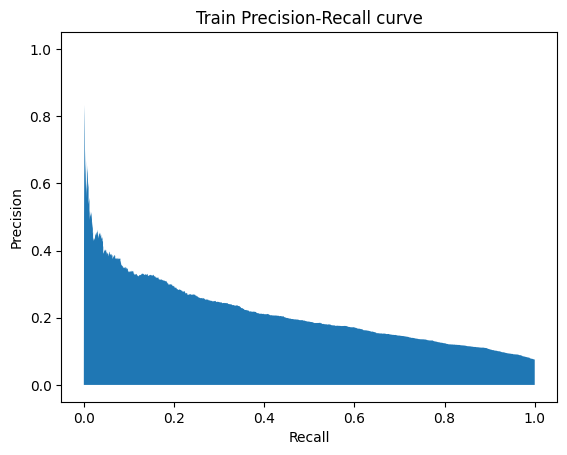

In [79]:
precision, recall, thresholds = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve")

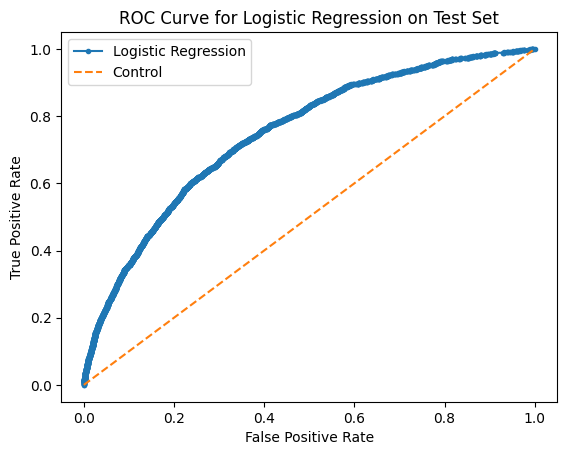

In [114]:
fpr, tpr, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
# axis labels
plt.plot([0, 1], [0, 1], linestyle='--', label='Control')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title('ROC Curve for Logistic Regression on Test Set')
plt.show()

Text(0.5, 1.0, 'Train Precision-Recall curve')

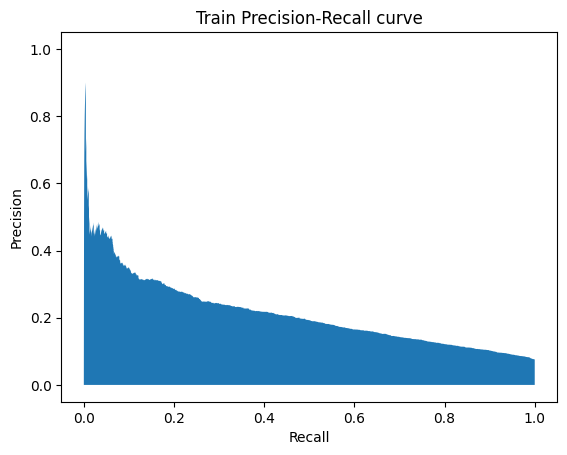

In [81]:
precision, recall, thresholds = precision_recall_curve(y_test, model_nn(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten())
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve")

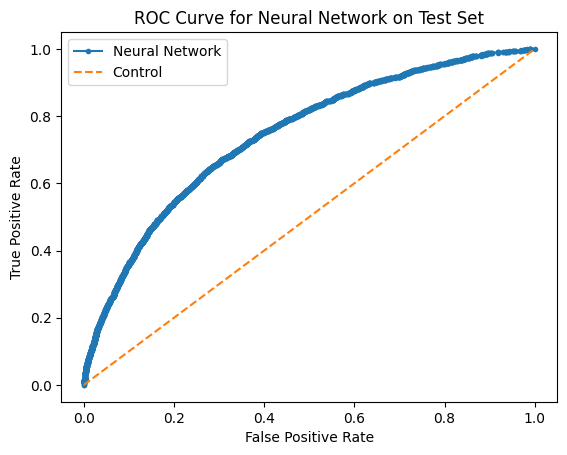

In [115]:
fpr, tpr, _ = roc_curve(y_test, model_nn(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten())
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Neural Network')
# axis labels
plt.plot([0, 1], [0, 1], linestyle='--', label='Control')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('ROC Curve for Neural Network on Test Set')
# show the plot
plt.show()

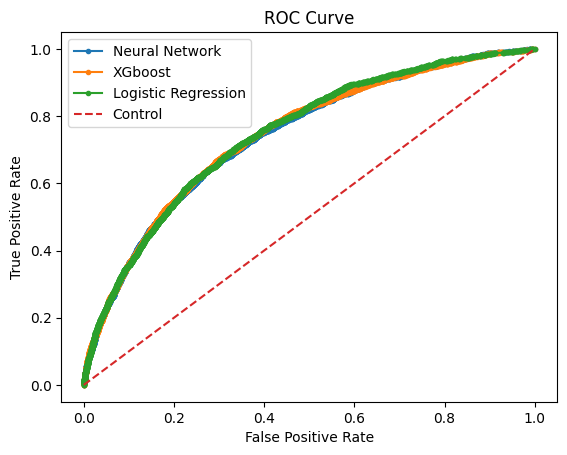

In [87]:
fpr_nn, tpr_nn, _ = roc_curve(y_test, model_nn(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten())
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
# plot model roc curve
plt.plot(fpr_nn, tpr_nn, marker='.', label='Neural Network')
plt.plot(fpr_xgb, tpr_xgb, marker='.', label='XGboost')
plt.plot(fpr_lr, tpr_lr, marker='.', label='Logistic Regression')
# axis labels
plt.plot([0, 1], [0, 1], linestyle='--', label='Control')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title('ROC Curve')
plt.show()

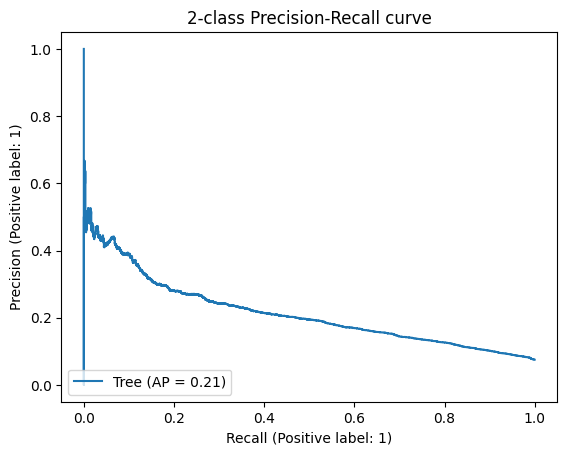

In [84]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    xgb_model, X_test, y_test, name="Tree"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

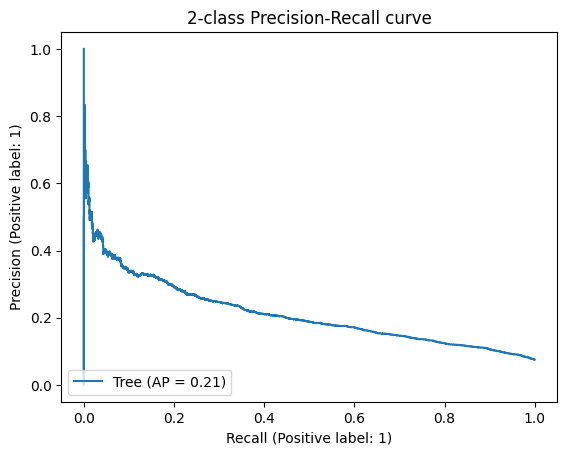

In [85]:
display = PrecisionRecallDisplay.from_estimator(
    logreg, X_test, y_test, name="Tree"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")